In [1]:
import numpy as np
import math
import operator
import networkx as nx
from itertools import permutations
import matplotlib.pyplot as plt
from deap import creator, base, tools, algorithms,gp
import dimod
import dwave_networkx as dnx
import import_ipynb
import tsp_parser
from tsp_parser import read_tsp_file
from operator import itemgetter
import pygraphviz as pgv
from IPython.display import Image 

importing Jupyter notebook from tsp_parser.ipynb
importing Jupyter notebook from city.ipynb


In [2]:
tsp = read_tsp_file('./symmetric_problems/berlin52.tsp')

In [3]:
len(tsp['CITIES'])

52

In [4]:
def plotGraph(G,show_weights=False):
    pos=nx.get_node_attributes(G,'coord')
    nx.draw(G,pos,with_labels=True)
    labels = nx.get_edge_attributes(G,'weight')
    if show_weights:
        nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

    plt.show()

In [5]:
def distance(A, B): 
    "The Euclidean distance between two cities."
    return math.sqrt( ((A[0]-B[0])**2)+((A[1]-B[1])**2) )

In [6]:
def total_distance(G):
    total =0
    for edge in G.edges: 
        total += distance(G.nodes[edge[0]]["pos"],G.nodes[edge[1]]["pos"])
    return total

In [7]:
G = nx.Graph()
G=nx.complete_graph(52)

In [8]:
for index,city in enumerate(tsp['CITIES']):
    G.nodes[index]['pos'] = (city.x,city.y)

In [9]:
nx.set_edge_attributes(G, values = 1, name = 'weight')

In [10]:
#G.add_weighted_edges_from({(0, 1,0.1), (0, 2, .5), (0, 3, .1), (1, 2, .1),(1, 3, .5), (2, 3, .1)})

In [11]:
G.is_directed()

False

In [12]:
G.has_edge(1,0)

True

In [ ]:
solution =[0]

In [ ]:
def near(edges,solution):
    distances =[]
    for edge in edges:      
        if edge[1] not in solution:
            distances.append({"distance":distance(G.nodes[edge[0]]['pos'],G.nodes[edge[1]]['pos']),"node":edge[1]}) 
    nearest = min(distances, key=lambda x:x['distance'])
    solution.append(nearest['node'])
    return nearest 

In [ ]:
for node in range(51):
    near(G.edges(solution[len(solution)-1]),solution)

In [ ]:
solution.append(solution[0])

In [ ]:
# pos=nx.get_node_attributes(G,'pos')
# nx.draw(G,pos,with_labels=True)
# labels = nx.get_edge_attributes(G,'weight')
# nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
# plt.show()

In [ ]:
G.clear_edges()

In [ ]:
for index in range(len(solution)-1):
    #print(solution[index],solution[index+1])
    G.add_edge(solution[index],solution[index+1])

In [ ]:
def plotGraph(G,show_weights=False):
    pos=nx.get_node_attributes(G,'pos')
    nx.draw(G,pos,with_labels=True)
    labels = nx.get_edge_attributes(G,'weight')
    if show_weights:
        nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

    plt.show()

In [ ]:
plotGraph(G)

In [ ]:
print(total_distance(G))

### DEAP EVOLUTIONARY ALGORITHMS

In [ ]:
toolbox = base.Toolbox()
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

In [ ]:
toolbox.register("indices", np.random.permutation, len(tsp['CITIES']))
toolbox.register("individual", tools.initIterate, creator.Individual,
                 toolbox.indices)
toolbox.register("population", tools.initRepeat, list, 
                 toolbox.individual)

In [ ]:
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)

In [ ]:
def create_tour(individual):
    G = nx.Graph()
    G=nx.complete_graph(len(individual))
    G.clear_edges()
    for index,city in enumerate(tsp['CITIES']):
        G.nodes[index]['pos'] = (city.x,city.y)
        
    for index in range(len(individual)-1):
        G.add_edge(individual[index],individual[index+1])
    G.add_edge(individual[len(individual)-1],individual[0])
    
    return G

In [ ]:
def evaluation(individual):
    return (total_distance(create_tour(individual)),)

In [ ]:
toolbox.register("evaluate", evaluation)

In [ ]:
toolbox.register("select", tools.selTournament, tournsize=3)

In [ ]:
pop = toolbox.population(n=100)

In [ ]:
plotGraph(create_tour(pop[2]))

In [ ]:
fit_stats = tools.Statistics(key=operator.attrgetter("fitness.values"))
fit_stats.register('mean', np.mean)
fit_stats.register('min', np.min)

In [ ]:
result, log = algorithms.eaSimple(pop, toolbox,
                             cxpb=0.8, mutpb=0.2,
                             ngen=400, verbose=False,stats=fit_stats)

In [ ]:
best_individual = tools.selBest(result, k=1)[0]
print('Fitness of the best individual: ', evaluation(best_individual)[0])

In [ ]:
G = create_tour(best_individual)

In [ ]:
plotGraph(G)

In [ ]:
plt.figure(figsize=(11, 4))
plots = plt.plot(log.select('min'),'c-', log.select('mean'), 'b-')
plt.legend(plots, ('Minimum fitness', 'Mean fitness'), frameon=True)
plt.ylabel('Fitness'); plt.xlabel('Iterations');
plt.title("berlin52 symetric graph")

### GENETIC PROGRAMMING

In [27]:
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1

In [28]:
def protectedMod(left, right):
    try:
        return left % right
    except ZeroDivisionError:
        return 1

In [29]:
pset = gp.PrimitiveSet("MAIN",4)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(protectedMod, 2)
#Number of nodes in the graph
pset.renameArguments(ARG0="Nn")
#Number of remaining nodes to visit
pset.renameArguments(ARG1="Nrn")
#Distance from the current node
pset.renameArguments(ARG2="Dcn")
#Distance from the initial node
pset.renameArguments(ARG3="Din")
#Distance from the centroid of the nodes
# pset.renameArguments(ARG0="Dc")
# #Predicted distance from the initial node
# pset.renameArguments(ARG0="Pd")
# #Distance left estimation
# pset.renameArguments(ARG0="Dle")

In [30]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

/Users/mac/opt/anaconda3/envs/tsp/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [31]:
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

/Users/mac/opt/anaconda3/envs/tsp/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [34]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=2, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
# toolbox.register("evaluate", evaluate, G)

In [35]:
pop = toolbox.population(n=300)

In [36]:
tree = gp.PrimitiveTree(pop[14]) 
string_tree = str(tree)
print(string_tree)

protectedMod(protectedMod(Nn, Din), add(Nrn, Din))


In [37]:
expr = toolbox.individual()

nodes, edges, labels = gp.graph(expr)

tree = gp.PrimitiveTree(expr)
string_tree = str(tree)
print(string_tree)

mul(protectedDiv(add(Nrn, Dcn), Dcn), protectedMod(add(Dcn, Dcn), Nn))


In [140]:
def evaluate(individual,G):
    tree = gp.PrimitiveTree(individual)
    string_tree = str(tree)
    print(string_tree)


    G.clear_edges()
    node_results = [0]
    current_node = 0
    initial_node =0
    visited = [0]
    solution = [0]
    for i in range(len(G.nodes)):
        results = []
        for index in range(len(G.nodes)):
            if index not in visited:
                Nn = len(G.nodes())
                Nrn = len(np.setdiff1d(list(G.nodes),visited))
                Dcn = distance(G.nodes[current_node]["pos"],G.nodes[index]["pos"])
                Din = distance(G.nodes[initial_node]["pos"],G.nodes[index]["pos"])
                result = toolbox.compile(expr=individual)
                results.append({"result": result(Nn,Nrn,Dcn,Din),"node":index})
        if not results:
            break
        nearest = min(results, key=lambda x:x['result'])
        G.add_edge(current_node,nearest["node"])
        solution.append(nearest["node"])
        current_node = nearest["node"]
        visited.append(nearest["node"])

    G.add_edge(initial_node,solution[len(solution)-1])
    return (total_distance(G),)

In [137]:
individual = toolbox.individual()
evaluate(individual,G)

mul(sub(Dcn, sub(Dcn, Nrn)), sub(mul(Dcn, Dcn), sub(Nn, Din)))


In [138]:
def plotGraph(G,show_weights=False):
    pos=nx.get_node_attributes(G,'pos')
    nx.draw(G,pos,with_labels=True)
    labels = nx.get_edge_attributes(G,'weight')
    if show_weights:
        nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

    plt.show()

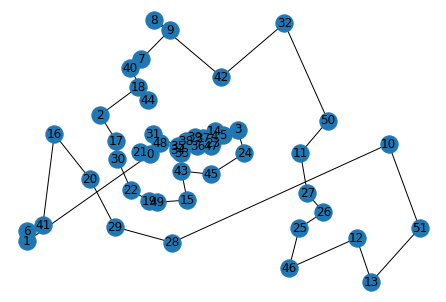

In [139]:
plotGraph(G)